## General Libraries

In [1]:
import os
import json
import requests
import webbrowser

In [2]:
import string

In [3]:
import time

In [4]:
from dotenv import load_dotenv

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt
import matplotlib

In [7]:
from requests_oauthlib import OAuth2Session

In [8]:
from nltk import word_tokenize
from nltk.corpus import stopwords

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Global Variables

In [10]:
path = os.path.expanduser("../data/")

load_dotenv(os.path.join(path, ".env"))

True

In [11]:
ID = os.getenv("GOOGLE_CLIENT_ID")
SECRET = os.getenv("GOOGLE_CLIENT_SECRET")

In [12]:
# loading my credentials
with open("../data/3D-soul.json") as fh:
    GOOGLE_APPLICATION_CREDENTIALS= json.loads(fh.read())
    
BASE_URL = GOOGLE_APPLICATION_CREDENTIALS["auth_uri"]
TOKEN_URL = GOOGLE_APPLICATION_CREDENTIALS["token_uri"]

In [13]:
SCOPES = ['https://www.googleapis.com/auth/contacts.readonly',
          "https://www.googleapis.com/auth/youtube.force-ssl",
          "https://www.googleapis.com/auth/youtube",
          "https://www.googleapis.com/auth/youtube.upload"]

REDIRECT = "https://console.developers.google.com/apis/dashboard?project=d-soul-297508"

## Authorization

In [14]:
# generating an  auth url
google = OAuth2Session(ID, scope=SCOPES, redirect_uri=REDIRECT)

authorization_url, state = google.authorization_url(BASE_URL,
                                                    access_type ="offline",
                                                    prompt="select_account")

In [15]:
webbrowser.open(authorization_url)

True

In [16]:
redirect_response = input("Enter the url:")

Enter the url:https://console.developers.google.com/apis/dashboard?project=d-soul-297508&state=qlIFlDcvcp7lpmBoGQFcU13KfHu3j9&code=4%2F0AY0e-g65-ci-Iut46RnFUEJj21HR5uMe0eOARdrWCp5Vg2KuxpIKXu44Kg2i7TcMG6YjbQ&scope=https:%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.upload%20https:%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube%20https:%2F%2Fwww.googleapis.com%2Fauth%2Fcontacts.readonly%20https:%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl


In [17]:
response = google.fetch_token(token_url=TOKEN_URL ,client_secret=SECRET, authorization_response=redirect_response)

In [142]:
# response

In [18]:
access_token = response["access_token"]

In [15]:
# access_token

### Functions

In [19]:
# Function to get the statistics of video_id
def get_statistics(video_id):
    url = "https://www.googleapis.com/youtube/v3/videos"
    pms = {"access_token" : access_token, "id" : video_id,
           "part" : "contentDetails, statistics"}
    res = requests.get(url, params = pms)
    data = res.json()   
    return data

# function to get video stats of channel id 
def get_channel_videos(channel_id):
    url = "https://www.googleapis.com/youtube/v3/search"
    pms = {"type" : "video", "access_token" : access_token, "channelId" : channel_id,
           "part" : "snippet", "order" : "viewCount", "maxResults" : 50}
    res = requests.get(url, params = pms)
    data = res.json() 
    
    lst = []
    for video in data["items"]:
        video_stats = get_statistics(video["id"]["videoId"])   
        
        try:
            c_cnt = video_stats["items"][0]["statistics"]["commentCount"]
        except:
            c_cnt = None
        
        res_json = {
            "channelTitle" : video["snippet"]["channelTitle"],
            "title" : video["snippet"]["title"],
            "publishedAt" : video["snippet"]["publishedAt"],
            "videoId" : video["id"]["videoId"],
            "viewCount" : video_stats["items"][0]["statistics"]["viewCount"],
            "commentCount" : c_cnt,
            "likeCount" : video_stats["items"][0]["statistics"]["likeCount"],
            "dislikeCount" :  video_stats["items"][0]["statistics"]["dislikeCount"]    
        }

        lst.append(res_json)
            
    df = pd.read_json(json.dumps(lst))
    return df
    

In [20]:
# a function to clean text data
def clean(text):
    tokens = word_tokenize(text.strip())
    clean = [wrd.lower() for wrd in tokens]
    clean = [wrd for wrd in clean if  wrd not in stopwords.words("english")]
    clean = [st for st in clean if st not in list(string.punctuation)]
    clean = [wrd for wrd in clean if len(wrd) > 1]
    
    return " ".join(clean)

In [221]:
# clean(df["comments"][3])

## Data Extraction

##### Get results for 50 video id's

In [22]:
## getting the id of playstation url
ps_url = "https://www.youtube.com/channel/UC-2Y8dQb0S6DtpxNgAKoJKA"

ps_id = ps_url.split("/")[-1]
# ps_id

In [23]:
# getting channel data for 50 similar video id's using google api
df = get_channel_videos(ps_id)

In [24]:
df.head()

,channelTitle,title,publishedAt,videoId,viewCount,commentCount,likeCount,dislikeCount
0,PlayStation,Hogwarts Legacy - Official Reveal Trailer | PS5,2020-09-16T20:17:47Z,1O6Qstncpnc,17006200,33387.0,556242,10426
1,PlayStation,The Road to PS5,2020-03-18T16:00:11Z,ph8LyNIT9sg,16300740,50331.0,346572,119539
2,PlayStation,Final Fantasy VII - E3 2015 Trailer | PS4,2015-06-16T01:54:47Z,Kznek1uNVsg,15975782,21836.0,140018,3157
3,PlayStation,[ENGLISH] PS5 - THE FUTURE OF GAMING SHOW,2020-06-11T21:29:17Z,RuLci-lSeCo,15489519,16622.0,519428,41244
4,PlayStation,First Look at the PlayStation 5 User Experience,2020-10-15T13:00:02Z,7TBPrYJDoDE,12759652,47173.0,521757,17048


In [44]:
df.shape

(5542, 3)

##### Get comments for a video id

In [25]:
## getting comments for specific video
yt_url = "https://www.youtube.com/watch?v=YQUpg795iBo"
yt_id = yt_url.split("/")[3].split("=")[1]
yt_id

'YQUpg795iBo'

In [26]:
# getting the statistics
url = "https://www.googleapis.com/youtube/v3/videos"
pms = {"part" : "snippet, statistics", "id" : yt_id, "access_token" : access_token}
res = requests.get(url, params = pms)
data = res.json() 

In [27]:
data["items"][0]["statistics"]

{'viewCount': '4349202',
 'likeCount': '51278',
 'dislikeCount': '3832',
 'favoriteCount': '0',
 'commentCount': '7999'}

In [28]:
# getting comments for video id
page = ""
url = "https://www.googleapis.com/youtube/v3/commentThreads"

full_data =[]
while True:
    pms = {"part":"snippet", "videoId":yt_id, "maxResults":50, 
       "access_token":access_token, "pageToken":page}
    res = requests.get(url, params=pms)
    print(f"Connection status:{res}")
    data = res.json()
    try:
        full_data.extend(data["items"])
        print(f"Just download: {len(data['items'])}, Total:{len(full_data)}")
        time.sleep(10)
    except:
        continue
    
    try:
        page = data["nextPageToken"]
    except:
        break    

Connection status:<Response [200]>
Just download: 50, Total:50
Connection status:<Response [200]>
Just download: 50, Total:100
Connection status:<Response [200]>
Just download: 50, Total:150
Connection status:<Response [200]>
Just download: 50, Total:200
Connection status:<Response [200]>
Just download: 50, Total:250
Connection status:<Response [200]>
Just download: 50, Total:300
Connection status:<Response [200]>
Just download: 50, Total:350
Connection status:<Response [200]>
Just download: 50, Total:400
Connection status:<Response [200]>
Just download: 50, Total:450
Connection status:<Response [200]>
Just download: 50, Total:500
Connection status:<Response [200]>
Just download: 50, Total:550
Connection status:<Response [200]>
Just download: 50, Total:600
Connection status:<Response [200]>
Just download: 50, Total:650
Connection status:<Response [200]>
Just download: 50, Total:700
Connection status:<Response [200]>
Just download: 50, Total:750
Connection status:<Response [200]>
Just d

In [278]:
# data

In [29]:
len(full_data)

5542

## Data Preprocessing

In [30]:
df = pd.DataFrame()

In [31]:
df["comments"] = [k["snippet"]["topLevelComment"]["snippet"]["textDisplay"] for k in full_data]
df["date"] = [k["snippet"]["topLevelComment"]["snippet"]["publishedAt"] for k in full_data]

In [32]:
df = df.set_index(["date"])
df.index = pd.to_datetime(df.index)

In [33]:
df.shape

(5542, 1)

In [34]:
df.head()

,comments
date,
2020-12-25 00:02:17+00:00,Im here just in case I get one Tomorrow for Ch...
2020-12-24 00:23:46+00:00,Ps5 now
2020-12-20 20:42:11+00:00,OH
2020-12-13 11:06:25+00:00,A new generation has begun.
2020-12-04 18:34:56+00:00,FRICK YOU SONY!!!!!! HOW DARE YOU FAKE DAFT PU...


In [35]:
# cleaning the comments
df["clean_comments"] = df["comments"].apply(clean)

In [36]:
# calculating polarity scores of cleaned comments
sentiment = SentimentIntensityAnalyzer()

df["sentiment"] = df["clean_comments"].apply(lambda txt:sentiment.polarity_scores(txt)["compound"])

In [47]:
## saving df to csv
df.to_csv("../data/yt-data.csv")

## Data Analysis

#### Questions 
- How does sentiment evolve over time? Are there any peaks?
- What are the periods when users comment more?
- what is the day of week when users put the most positive comments
- what is the day of the week they comment most actively

#### Answers
- Yes there are many postive peaks but on beginning of **2015** we can se a negative peak
- 2014-2015
- Friday has more comments

In [37]:
# small analysis on sentiment scores
print(f"""no of positive scores: {(df['sentiment']>0).sum()}
no of negative scores: {(df['sentiment']<0).sum()}
no of zero scores: {(df['sentiment']==0).sum()} 

total non-zero scores: {(df['sentiment']!=0).sum()}  
""")

no of positive scores: 2238
no of negative scores: 1038
no of zero scores: 2266 

total non-zero scores: 3276  



##### sentiment by month

In [38]:
df['sentiment'].resample("M").mean().head()

date
2013-11-30 00:00:00+00:00    0.108454
2013-12-31 00:00:00+00:00    0.207058
2014-01-31 00:00:00+00:00    0.130790
2014-02-28 00:00:00+00:00    0.338627
2014-03-31 00:00:00+00:00    0.234737
Freq: M, Name: sentiment, dtype: float64

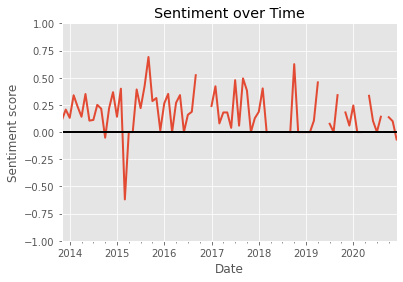

In [39]:
## Plotting the data
matplotlib.style.use("ggplot")

df['sentiment'].resample("M").mean().plot(
    title = "Sentiment over Time", lw=2, ylim=(-1,1))

plt.axhline(0, color="k", lw=2)
plt.xlabel("Date")
plt.ylabel("Sentiment score")

plt.show()

##### sentiment by weekday

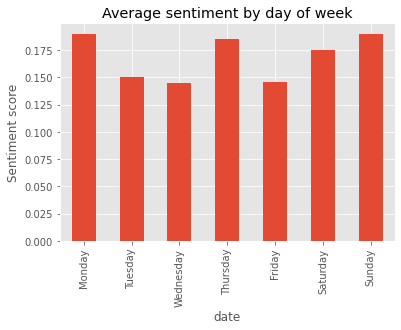

In [40]:
dx = df[df.index > '2013-11-18']
ax = dx.groupby(dx.index.weekday)["sentiment"].mean().plot(kind="bar", title="Average sentiment by day of week")
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylabel("Sentiment score")
plt.show()

##### comments in time

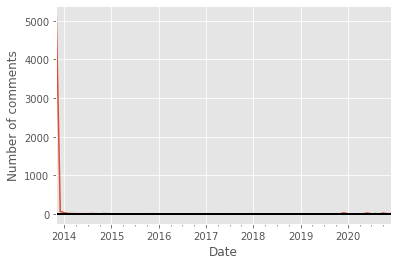

In [41]:
df["sentiment"].resample("M").count().plot()

plt.axhline(0, color="k", lw=2)
plt.xlabel("Date")
plt.ylabel("Number of comments")

plt.show()

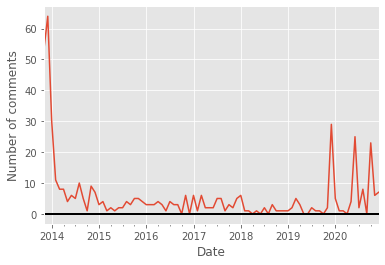

In [42]:
dx = df[df.index > '2013-11-18']
dx["sentiment"].resample("M").count().plot()

plt.axhline(0, color="k", lw=2)
plt.xlabel("Date")
plt.ylabel("Number of comments")
plt.show()

##### No of comments by weekday

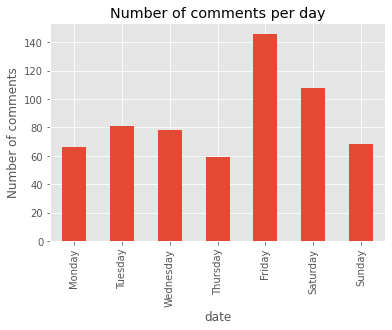

In [43]:
dx = df[df.index > '2013-11-15']

ax = dx.groupby(dx.index.weekday)["comments"].count().plot(kind="bar", title="Number of comments per day")
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.ylabel("Number of comments")

plt.show()